# This is my first Agent Based Model. I attempt at recreating a simple SRI model.

As I am trying to learn Agent Based Modelling it ocurred to me that this would be a nice option, and relevant for the current times. I attempt to write simple code and  use simple behavioral and interaction rules. I found inspiration in tutorials online such as this one: https://github.com/Limor-Raviv/Tutorial_Agent_Based_Models. In the SRI model we subset the population into three major groups, namely Susceptible, Infected, Recovered. Herein I attempt at recreating the same dynamics described by the equations of the mathematical model, but extend it to include death and the effects of a quarentine!


*Elías Mantilla José Ibarra*

In [1]:
# importing necessary libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(rc={'figure.figsize':(15,5)})

The agent class was to desing to have objects the could retain important information such as inner state or a boolean representing the condition of isolation.

In [2]:
class Agent(object):
    """Agent class contains constructor and function to change agent's inner state"""
    
    def __init__(self, state):
        self.state = state
        self.since_infected = 0
        self.infected = self.is_infected()
        self.in_quarentine = False
        
        
    def is_infected(self):
        """
        Check whether agent is infected
        
        :returns : bool 
        """
        return self.state == 'I'
    
    def become_recovered(self):
        """Change the agent inner state to recovered"""
        if self.since_infected == 5:
            self.state = 'R'
        else:
            self.state = self.state

    def recovered_or_dead(self, death_rate):
        """Change agent's state to 'D' death with certain probability, otherwise change it to Recovered"""
        if self.since_infected == 5:
            randnum = np.random.uniform()
            if randnum < death_rate:
                self.state = 'D'
            else:
                self.state = 'R'
        else:
            self.state = self.state

In [3]:
def create_population(N, i):
    """
    Generate a population of agents
    
    :returns: list
    """
    
    population = []
     # generate number of infected agents
    for _ in range(i):
        agent = Agent(state = 'I')
        population.append(agent)
    
    # generate N - i susceptible agents
    for _ in range(N - i):
        agent = Agent(state = 'S')
        population.append(agent)
        
    return population

In [4]:
def count(population):
    """
    Get the fraction of the population belonging to each state
    
    :returns: three floats representing the proportion of Infected, Susceptible, Recovered populations
    :rtype: float
    """
    
    s = 0
    r = 0
    i = 0
    
    # loop over the agents' list and add a unit to each different counter for different types
    for agent in population:
        if agent.state == 'I':
            i += 1
        elif agent.state == 'S':
            s += 1
        elif agent.state == 'R':
            r += 1
    return i / len(population), s / len(population), r / len(population)

In [5]:
def count_whole(population, S):
    """
    Get the total number of agent in a particular state
    
    :returns: integer representing total count of agents
    """
    var = 0
    for agent in population:
        if agent.state == S:
            var += 1
    return var

In [6]:
def choose_pair(population):
    """
    Select two agents from the population list
    
    :returns: two agent instances
    :rtype: Agent.class
    """
    
    i = np.random.choice(population)
    j = np.random.choice(population)
    
    # if selected the same agent twice select another agent for the second place
    while i == j:
        j = np.random.choice(population)
        
    return i, j

In [7]:
def interact(agent1, agent2):
    """
    Function to allow agents to change their inner states in response to other agents
    """
    
    # if agents' state are the same, they remain with the same state
    if agent1.state == agent2.state:
        return agent1, agent2
    # If any of the two agents is infected, make both agents infected, \
    # except if the other is recovered
    elif agent1.state == 'I' or agent2.state == 'I':
        if agent1.state == 'R' or agent2.state == 'R':
            return agent1, agent2
        else:
            agent1.state = 'I'
            agent2.state = 'I'
            return agent1, agent2

In [8]:
def simulate(T, N, i):
    """
    Run a simulation
    
    :returns: lists with different variables to track
    :rtype: list(s)
    """
    
    population = create_population(N, i)
    proportion_infected = []
    proportion_susceptible = []
    proportion_recovered = []
    count_infected = []
    
    for _ in range(T):
        
        pair = choose_pair(population)
        interact(pair[0], pair[1])
        
        pair[0].become_recovered()
        pair[1].become_recovered()
        
        if pair[0].is_infected():
            pair[0].since_infected += 1
            
        if pair[1].is_infected():
            pair[1].since_infected += 1
        
        proportion_infected.append(count(population)[0])
        proportion_susceptible.append(count(population)[1])
        proportion_recovered.append(count(population)[2])
        count_infected.append(count_whole(population, 'I'))
        
    return proportion_infected, proportion_susceptible, proportion_recovered, count_infected

In [9]:
# Run an example simulation
results_i, results_s, results_r, total_infected = simulate(10000, 1000, 10)

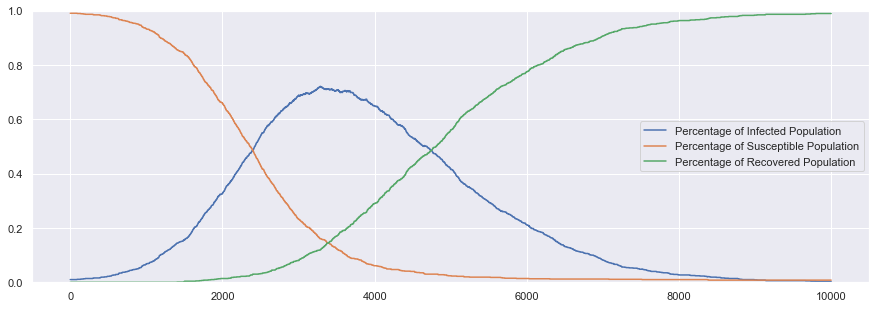

In [10]:
# Plot main variables and their evolution over each time step
_ = plt.plot(results_i, label = 'Percentage of Infected Population')
_ = plt.plot(results_s, label = 'Percentage of Susceptible Population')
_ = plt.plot(results_r, label = 'Percentage of Recovered Population')
_ = plt.legend()
_ = plt.ylim(0,1)

As shown in the plot, the dynamics described by the agents interactions resemble the graphs drawn fromt the differential equations in the S-R-I model.

In [11]:
# Create a pandas dataframe with the relevant information
list_keys = ['Infected', 'Susceptible', 'Recovered', 'Infected_Total']
list_values = [results_i, results_s, results_r, total_infected]
mdl_results = pd.DataFrame(dict(list(zip(list_keys, list_values))))

In [12]:
# Broadcast a new column for a new case for each time step
mdl_results['new_Case'] =  [0] + list(np.diff(mdl_results['Infected_Total'].values))

In [13]:
# Remove negative numbers
mdl_results['new_Case'][mdl_results['new_Case'] < 0] = 0

C:\Users\Elias\miniconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [14]:
# Create two new splits of new_Case and the index so as to be able to get a histogram
new_cases_100 = mdl_results.new_Case.values.reshape(-1, 100).sum(axis=1)
index_100 = [_ for _ in mdl_results.index if _%100==0]

<BarContainer object of 100 artists>

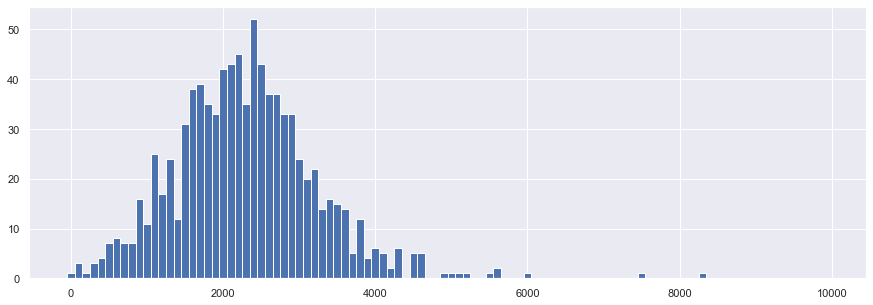

In [15]:
# plot a histogram showcasing new cases every one hundred periods
plt.bar(x=index_100, height=new_cases_100, width=100)

## Next Step Implementing Deaths
After agents have been infected for some time, they either die or become recovered

In [16]:
def count_deaths(population):
    """
    Get the fraction of the population belonging to each state
    
    :returns: three floats representing the proportion of Infected, Susceptible, Recovered populations
    :rtype: float
    """
    
    s = 0
    r = 0
    i = 0
    d = 0
    
    for agent in population:
        if agent.state == 'I':
            i += 1
        elif agent.state == 'S':
            s += 1
        elif agent.state == 'R':
            r += 1
        elif agent.state == 'D':
            d += 1
    return i / len(population), s / len(population), r / len(population), d / len(population)

In [17]:
def choose_pair_deaths(population):
    """
    Select two agents from the population list
    
    :returns: two agent instances
    :rtype: Agent.class
    """
    
    # must preclude agents with inner state 'D'
    population_alive = [_ for _ in population if _.state != 'D']
    
    i = np.random.choice(population_alive)
    j = np.random.choice(population_alive)
    
    while i == j:
        j = np.random.choice(population_alive)
        
    return i, j

In the design of this new simulation function I had to add another method to the class Agent. In this newer method, after some time steps being infected, the agent either becomes dead, with a certain probability, or becomes recovered.

In [20]:
def simulate_deaths(T, N, i, death_rate = 0.15):
    """
    Run a simulation
    
    :returns: lists with different variables to track
    :rtype: list(s)
    """
    population = create_population(N, i)
    proportion_infected = []
    proportion_susceptible = []
    proportion_recovered = []
    proportion_dead = []
    
    for _ in range(T):
        
        pair = choose_pair_deaths(population)
        interact(pair[0], pair[1])
        
        # Once the agents are recovered they can't become dead
        if pair[0].state != 'R':
            pair[0].recovered_or_dead(death_rate)
        
        if pair[1].state != 'R':
            pair[1].recovered_or_dead(death_rate)
        
        # Update inner counter to decide when agent's becoming dead or recovered
        if pair[0].is_infected():
            pair[0].since_infected += 1
            
        if pair[1].is_infected():
            pair[1].since_infected += 1
        
        proportion_infected.append(count_deaths(population)[0])
        proportion_susceptible.append(count_deaths(population)[1])
        proportion_recovered.append(count_deaths(population)[2])
        proportion_dead.append(count_deaths(population)[3])

    return proportion_infected, proportion_susceptible, proportion_recovered, proportion_dead

In [21]:
# Run a simulation specifying death rate
I, S, R, D = simulate_deaths(10000, 1000, 10, death_rate = 0.1)

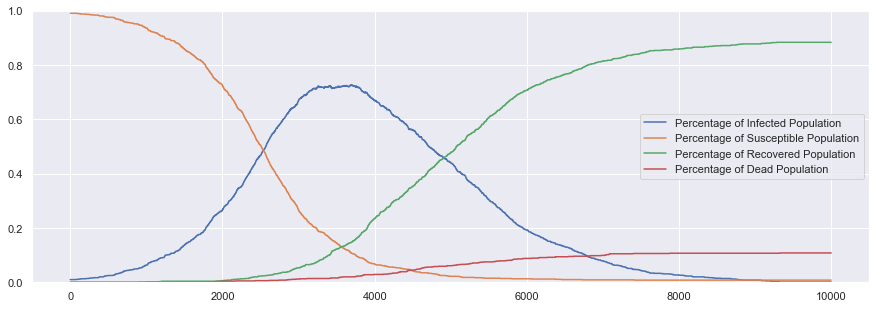

In [22]:
_ = plt.plot(I, label = 'Percentage of Infected Population')
_ = plt.plot(S, label = 'Percentage of Susceptible Population')
_ = plt.plot(R, label = 'Percentage of Recovered Population')
_ = plt.plot(D, label = 'Percentage of Dead Population')
_ = plt.legend()
_ = plt.ylim(0,1)

In [23]:
# Run another example simulation with a slighly smaller death rate
I, S, R, D = simulate_deaths(10000, 1000, 10, death_rate = 0.05)

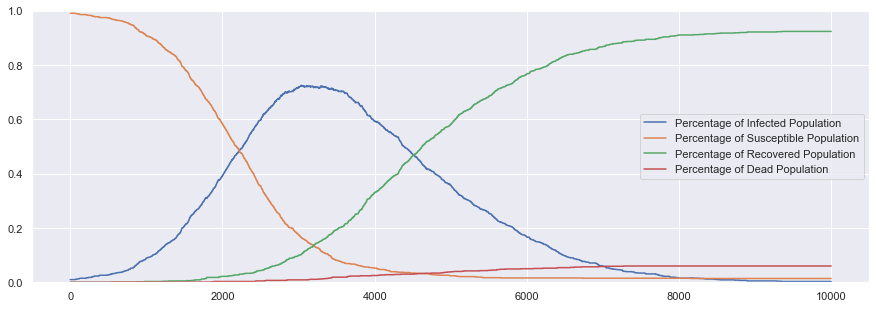

In [24]:
_ = plt.plot(I, label = 'Percentage of Infected Population')
_ = plt.plot(S, label = 'Percentage of Susceptible Population')
_ = plt.plot(R, label = 'Percentage of Recovered Population')
_ = plt.plot(D, label = 'Percentage of Dead Population')
_ = plt.legend()
_ = plt.ylim(0,1)

## Implementing a Quaretine

In [25]:
def choose_pair_quarentine(population):
    
    """
    Select two agents from the population list
    
    :returns: two agent instances
    :rtype: Agent.class
    """
    
    # Here must preclude from interaction agents that are death or in_quarentine
    population_alive = [_ for _ in population if _.state != 'D']
    not_in_quarentine = [_ for _ in population_alive if _.in_quarentine == False]
    
    i = np.random.choice(not_in_quarentine)
    j = np.random.choice(not_in_quarentine)
    
    while i == j:
        j = np.random.choice(not_in_quarentine)
        
    return i, j

In [26]:
def simulate_quarentine(T, N, i, death_rate = 0.15, beginning = 0.25, end = 0.75):
    
    """
    Run a simulation
    
    :returns: lists with different variables to track
    :rtype: list(s)
    """
    
    population = create_population(N, i)
    proportion_infected = []
    proportion_susceptible = []
    proportion_recovered = []
    proportion_dead = []
    
    for i, _ in enumerate(range(T)):
        
        # at time step T*beginning loop over the agents and get a fraction of them to self quarentine
        if i == int(T * beginning):
            for agent in population:
                agent.in_quarentine = True if np.random.uniform() < 0.40 else False
        
        # at time step T*end loop over the agents getting all of them to end quarentine
        if i == int(T * end):
            for agent in population:
                agent.in_quarentine = False
                
        pair = choose_pair_quarentine(population)
        interact(pair[0], pair[1])
        
        if pair[0].state != 'R':
            pair[0].recovered_or_dead(death_rate)
        
        if pair[1].state != 'R':
            pair[1].recovered_or_dead(death_rate)
        
        if pair[0].is_infected():
            pair[0].since_infected += 1
            
        if pair[1].is_infected():
            pair[1].since_infected += 1
        
        proportion_infected.append(count_deaths(population)[0])
        proportion_susceptible.append(count_deaths(population)[1])
        proportion_recovered.append(count_deaths(population)[2])
        proportion_dead.append(count_deaths(population)[3])

    return proportion_infected, proportion_susceptible, proportion_recovered, proportion_dead

In [27]:
# Run a simulation specifying death rate, beginning and end of a quarentine
I, S, R, D = simulate_quarentine(20000, 1000, 10, death_rate = 0.1, beginning = 0.05, end = 0.5)

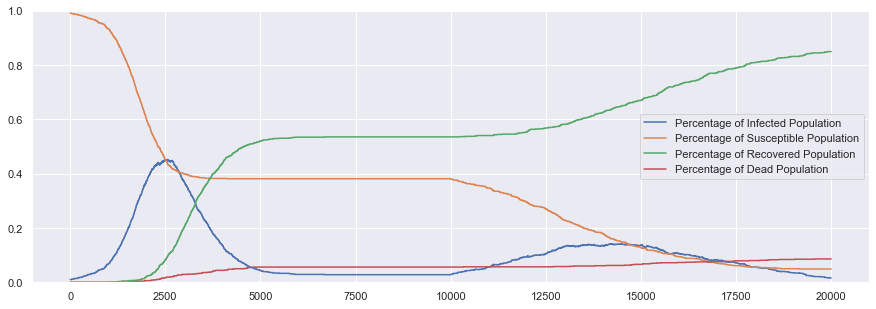

In [28]:
_ = plt.plot(I, label = 'Percentage of Infected Population')
_ = plt.plot(S, label = 'Percentage of Susceptible Population')
_ = plt.plot(R, label = 'Percentage of Recovered Population')
_ = plt.plot(D, label = 'Percentage of Dead Population')
_ = plt.legend()
_ = plt.ylim(0,1)